In [3]:

import datetime
import pandas as pd
from pandas import DataFrame
import scipy
import seaborn as sns
from src.common.utils import *
import numpy as np
import scipy.stats
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')


def get_n_latest_logs(environment, n, reward,logging_path = None):
    if logging_path is None:
        # TODO change for value
        logging_path = os.path.join(get_logs_dir(algorithm="policy"), environment)
        assert "master-thesis" in logging_path
        
    dir_files = []
    for subdir, _, files in os.walk(logging_path):
        if subdir is logging_path:
            continue
        date = subdir.replace(logging_path + "/", "")
        date = datetime.datetime.strptime(date, "%b-%d_%H:%M:%S")
        idx = 2 if reward else 0#'log_rewards.csv' if reward else 'log.csv'
        #f = [file for file in files if file==(file_name)][0]

        dir_files.append((date, subdir, files[idx])) # ['log.csv', 'params.json', 'log_rewards.csv']

    dir_files = sorted(dir_files, key=lambda x: x[0], reverse=False)  # sort by date
    latest_logs = [(dir, file) for _, dir, file in dir_files[-n:]]
    files = [ f"{di}/{f}" for  di, f in latest_logs]
    return files
 
def get_data(categories, experiments, environment, n_latest_logs, reward=False):
    data = []
    for category, experiment in zip(categories, experiments):
        # todo inject 
        d = os.path.join(get_root_dir(), "data", "policy", 'results', experiment, environment)
  
        logs = get_n_latest_logs(environment, n_latest_logs, reward, logging_path=d)
      
        logs = [pd.read_csv(i, delimiter=",") for i in logs]
        
        for n, _ in enumerate(logs):
            logs[n].insert(0, "run", n)
        
        frame = pd.concat(logs)
        frame.insert(0, "category", category) # append the category to compare
        data.append(frame)
        
    return pd.concat(data)

def smooth(y, radius, mode='two_sided', valid_only=False):
    # see: https://github.com/openai/baselines/blob/master/baselines/common/plot_util.py
    assert mode in ('two_sided', 'causal')
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        out = np.convolve(y, convkernel,mode='same') / np.convolve(np.ones_like(y), convkernel, mode='same')
        if valid_only:
            out[:radius] = out[-radius:] = np.nan
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / np.convolve(np.ones_like(y), convkernel, mode='full')
        out = out[:-radius+1]
        if valid_only:
            out[:radius] = np.nan
    return out

def one_sided_ema(xolds, yolds, low=None, high=None, n=512, decay_steps=1., low_counts_threshold=1e-8):
    # see: https://github.com/openai/baselines/blob/master/baselines/common/plot_util.py
    low = xolds[0] if low is None else low
    high = xolds[-1] if high is None else high

    assert xolds[0] <= low, 'low = {} < xolds[0] = {} - extrapolation not permitted!'.format(low, xolds[0])
    assert xolds[-1] >= high, 'high = {} > xolds[-1] = {}  - extrapolation not permitted!'.format(high, xolds[-1])
    assert len(xolds) == len(yolds), 'length of xolds ({}) and yolds ({}) do not match!'.format(len(xolds), len(yolds))


    xolds = xolds.astype('float64')
    yolds = yolds.astype('float64')

    luoi = 0 # last unused old index
    sum_y = 0.
    count_y = 0.
    xnews = np.linspace(low, high, n)
    decay_period = (high - low) / (n - 1) * decay_steps
    interstep_decay = np.exp(- 1. / decay_steps)
    sum_ys = np.zeros_like(xnews)
    count_ys = np.zeros_like(xnews)
    for i in range(n):
        xnew = xnews[i]
        sum_y *= interstep_decay
        count_y *= interstep_decay
        while True:
            if luoi >= len(xolds):
                break
            xold = xolds[luoi]
            if xold <= xnew:
                decay = np.exp(- (xnew - xold) / decay_period)
                sum_y += decay * yolds[luoi]
                count_y += decay
                luoi += 1
            else:
                break
        sum_ys[i] = sum_y
        count_ys[i] = count_y

    ys = sum_ys / count_ys
    ys[count_ys < low_counts_threshold] = np.nan

    return xnews, ys, count_ys

def symmetric_ema(xolds, yolds, low=None, high=None, n=512, decay_steps=1., low_counts_threshold=1e-8):
    # see: https://github.com/openai/baselines/blob/master/baselines/common/plot_util.py
    xs, ys1, count_ys1 = one_sided_ema(xolds, yolds, low, high, n, decay_steps, low_counts_threshold=0)
    _,  ys2, count_ys2 = one_sided_ema(-xolds[::-1], yolds[::-1], -high, -low, n, decay_steps, low_counts_threshold=0)
    ys2 = ys2[::-1]
    count_ys2 = count_ys2[::-1]
    count_ys = count_ys1 + count_ys2
    ys = (ys1 * count_ys1 + ys2 * count_ys2) / count_ys
    ys[count_ys < low_counts_threshold] = np.nan
    return xs, ys, count_ys


def resample_results(data, categories, runs=6, x_col="step", y_col="MeanReward", x_max=1_000_000, samples=512):
    xs = np.linspace(0, x_max, samples)
    df = pd.DataFrame(columns=['x', 'y', 'run', "category"])
    for c in categories:
        d_cat = data[data["category"]==c]
        for i in range(0,runs):
            run = d_cat[d_cat["run"]==i]
            x = run[x_col].values
            y = run[y_col].values
            _, ys, _ = symmetric_ema(x, y, x[0], x[-1], samples)
            app = pd.DataFrame(columns=['x', 'y', 'run', "category"])
            app["x"] = xs        
            app["y"] = ys
            app["run"] = i
            app["category"] = c
            df = df.append(app)
    return df

dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

def plot_resampled(env, cats, runs=6, x_col="step", y_col="MeanReward", x_max=1_000_000, samples=512):
    df = get_data(cats,cats, env, 6)
    df = resample_results(df, cats, x_col=x_col, y_col=y_col, x_max=x_max, samples=samples)
    ax = sns.lineplot(x="x", y = "y",hue="category",markers=False,dashes=dash_styles,style="category",data=df)
    return ax

default_environments = ["FetchReach-v1", "InvertedDoublePendulum-v2", "Hopper-v2", "Walker2d-v2"]
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("whitegrid", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})

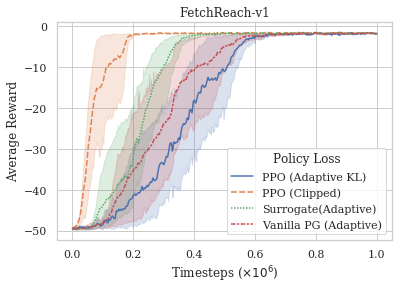

In [4]:
env = "FetchReach-v1"
cats = ["ppo-test-loss-adaptive_kl","ppo-test-loss-clipped_kl","ppo-test-loss-surrogate","ppo-test-loss-pg"]
ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
labels = ['PPO (Adaptive KL)', 'PPO (Clipped)', 'Surrogate(Adaptive)', 'Vanilla PG (Adaptive)']
ax.legend(title='Policy Loss', loc='lower right', labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"pg-losses-{env}.pdf", bbox_inches="tight")



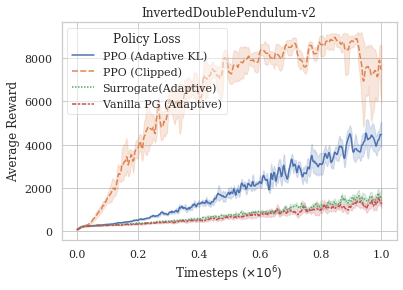

In [5]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-loss-adaptive_kl","ppo-test-loss-clipped_kl","ppo-test-loss-surrogate","ppo-test-loss-pg"]
ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
labels = ['PPO (Adaptive KL)', 'PPO (Clipped)', 'Surrogate(Adaptive)', 'Vanilla PG (Adaptive)']
ax.legend(title='Policy Loss', loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"pg-losses-{env}.pdf", bbox_inches="tight")




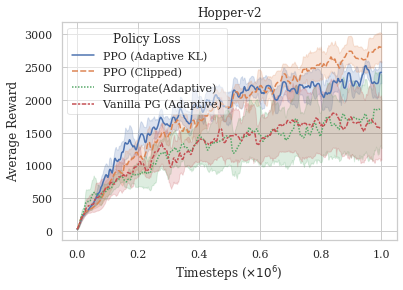

In [71]:
env = "Hopper-v2"
cats = ["ppo-test-loss-adaptive_kl","ppo-adaptive-10","ppo-test-loss-surrogate","ppo-test-loss-pg"]
ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
labels = ['PPO (Adaptive KL)', 'PPO (Clipped)', 'Surrogate(Adaptive)', 'Vanilla PG (Adaptive)']
ax.legend(title='Policy Loss', loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"pg-losses-{env}.pdf", bbox_inches="tight")





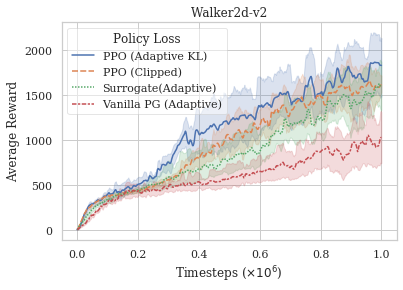

In [67]:
env = "Walker2d-v2"
cats = ["ppo-test-loss-adaptive_kl","ppo-test-loss-clipped_kl","ppo-test-loss-surrogate","ppo-test-loss-pg"]
ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
labels = ['PPO (Adaptive KL)', 'PPO (Clipped)', 'Surrogate(Adaptive)', 'Vanilla PG (Adaptive)']
ax.legend(title='Policy Loss', loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"pg-losses-{env}.pdf", bbox_inches="tight")






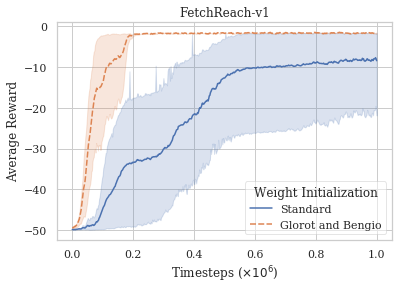

In [18]:
env = "FetchReach-v1"
cats = ["ppo-test-kernel_initializer","ppo-test-loss-clipped_kl"]
exp = "ppo-kernel_initializer"
labels = [r'Standard', 'Glorot and Bengio']
legend_title = 'Weight Initialization'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


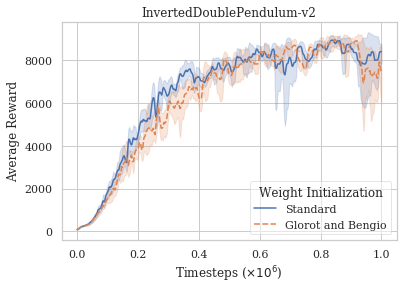

In [19]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-kernel_initializer","ppo-test-loss-clipped_kl"]
exp = "ppo-kernel_initializer"
labels = [r'Standard', 'Glorot and Bengio']
legend_title = 'Weight Initialization'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


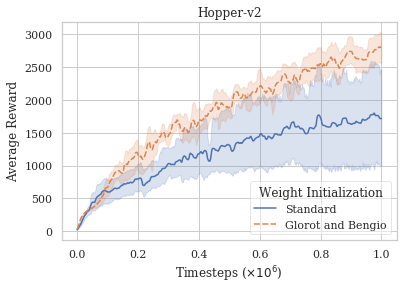

In [22]:
env = "Hopper-v2"
cats = ["ppo-test-kernel_initializer","ppo-adaptive-10"]
exp = "ppo-kernel_initializer"
labels = [r'Standard', 'Glorot and Bengio']
legend_title = 'Weight Initialization'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")



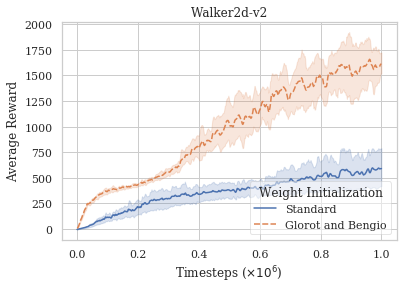

In [21]:
env = "Walker2d-v2"
cats = ["ppo-test-kernel_initializer","ppo-test-loss-clipped_kl"]
exp = "ppo-kernel_initializer"
labels = [r'Standard', 'Glorot and Bengio']
legend_title = 'Weight Initialization'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


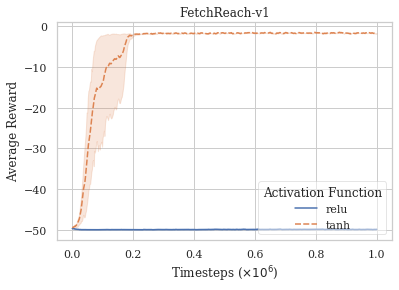

In [80]:
env = "FetchReach-v1"
cats = ["ppo-test-relu","ppo-test-loss-clipped_kl"]
exp = "ppo-test-relu"
labels = ['relu', 'tanh']
legend_title = 'Activation Function'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


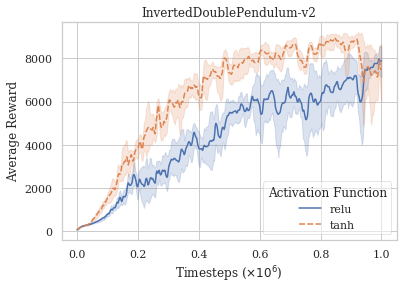

In [81]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-relu","ppo-test-loss-clipped_kl"]
exp = "ppo-test-relu"
labels = ['relu', 'tanh']
legend_title = 'Activation Function'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


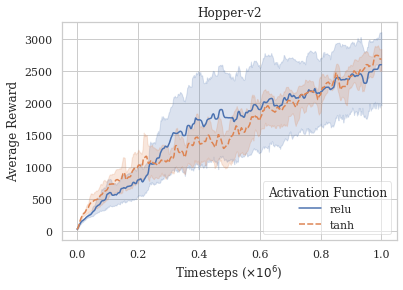

In [82]:
env = "Hopper-v2"
cats = ["ppo-test-relu","ppo-test-loss-clipped_kl"]
exp = "ppo-test-relu"
labels = ['relu', 'tanh']
legend_title = 'Activation Function'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


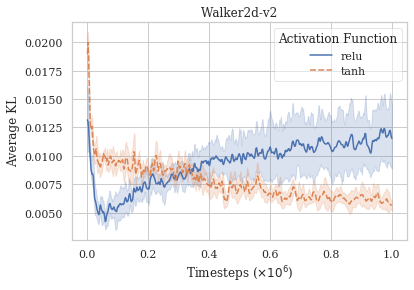

In [116]:
env = "Walker2d-v2"
cats = ["ppo-test-relu","ppo-test-loss-clipped_kl"]
exp = "ppo-test-relu"
labels = ['relu', 'tanh']
legend_title = 'Activation Function'

ax = plot_resampled(env,cats,y_col="KL")
ax.set_ylabel("Average KL")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='upper right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"ppo-test-relu-Walker2d-v2-kl.pdf", bbox_inches="tight")



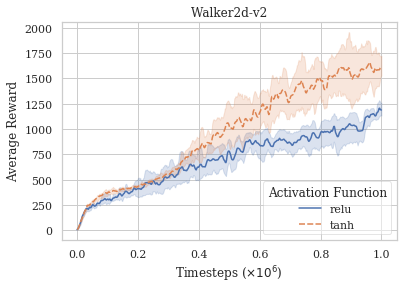

In [114]:
env = "Walker2d-v2"
cats = ["ppo-test-relu","ppo-test-loss-clipped_kl"]
exp = "ppo-test-relu"
labels = ['relu', 'tanh']
legend_title = 'Activation Function'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


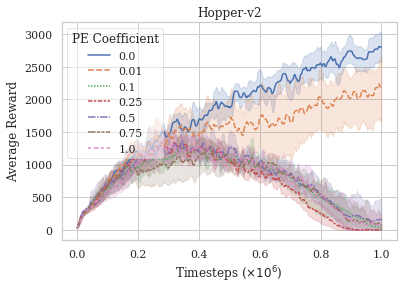

In [93]:
env = "Hopper-v2"
cats = [f"ppo-adaptive-10"]+[f"ppo-test-entropy_coef{coef}" for coef in ["",0.1,0.25,0.5, 0.75, 1.0]]
exp = "ppo-test-relu"
labels = [0.0, 0.01,0.1,0.25,0.5, 0.75, 1.0]
legend_title = 'PE Coefficient'

df = get_data(cats,cats, env, 6)
df["MeanReward"]=df["MeanReward"].apply(lambda x: max(0, x)) # ignore negative values
df = resample_results(df, cats)
ax = sns.lineplot(x="x", y = "y",hue="category",markers=False,dashes=dash_styles,style="category",data=df)

ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"ppo-test-pec.pdf", bbox_inches="tight")


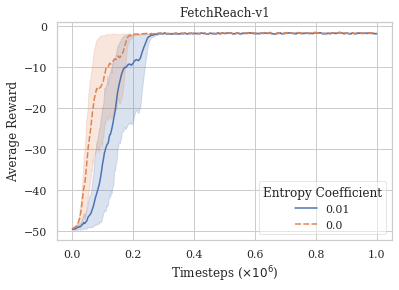

In [94]:
env = "FetchReach-v1"
cats = ["ppo-test-entropy_coef","ppo-test-loss-clipped_kl"]
exp = "ppo-test-entropy-coef"
labels = ['0.01', '0.0']
legend_title = 'Entropy Coefficient'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


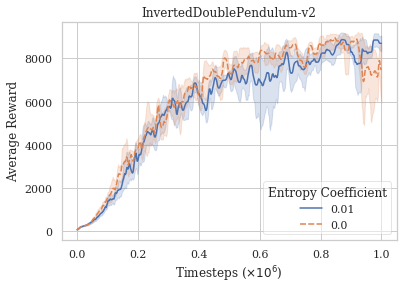

In [95]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-entropy_coef","ppo-test-loss-clipped_kl"]
exp = "ppo-test-entropy-coef"
labels = ['0.01', '0.0']
legend_title = 'Entropy Coefficient'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


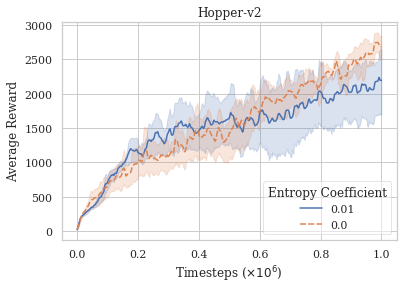

In [96]:
env = "Hopper-v2"
cats = ["ppo-test-entropy_coef","ppo-test-loss-clipped_kl"]
exp = "ppo-test-entropy-coef"
labels = ['0.01', '0.0']
legend_title = 'Entropy Coefficient'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

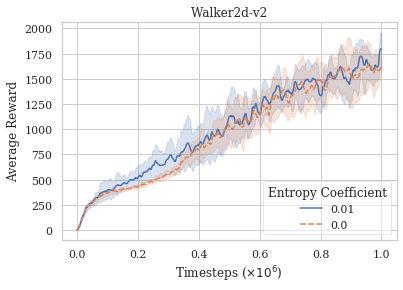

In [97]:
env = "Walker2d-v2"
cats = ["ppo-test-entropy_coef","ppo-test-loss-clipped_kl"]
exp = "ppo-test-entropy-coef"
labels = ['0.01', '0.0']
legend_title = 'Entropy Coefficient'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

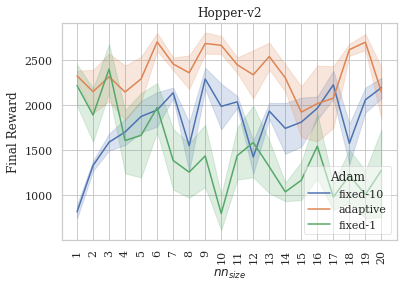

In [34]:
env = "Hopper-v2"
col= "MeanReward"
description = r"Final Reward"
final = True

start_size = 1
end_size = 21

data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data4 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env, 6)
data4.insert(0, "category2", "fixed1") # append the category to compare

data = pd.concat([data,data2, data4])
data["category"] = data["category"].apply(lambda x: x.replace("fixed20","adaptive")).apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")



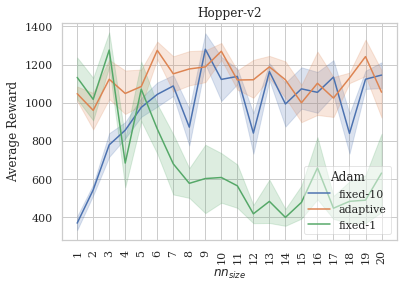

In [32]:
env = "Hopper-v2"
col= "MeanReward"
description = r"Average Reward"
final = False

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env, 6)

data3.insert(0, "category2", "fixed20") # append the category to compare

data = pd.concat([data,data2,data3])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")




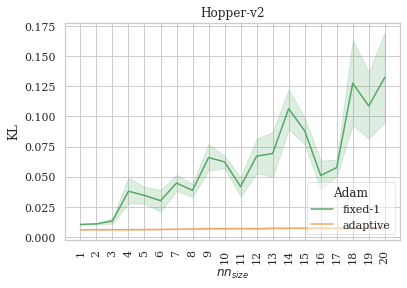

In [62]:
env = "Hopper-v2"
col= "KL"
description = r"KL"
final = False

start_size = 1
end_size = 21

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env, 6)

data3.insert(0, "category2", "fixed1") # append the category to compare

data = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data.insert(0, "category2", "adaptive") # append the category to compare

data = pd.concat([data3,data])


data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()



enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g, palette=sns.color_palette(["g","sandybrown"]))
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-1','adaptive'])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-1-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")





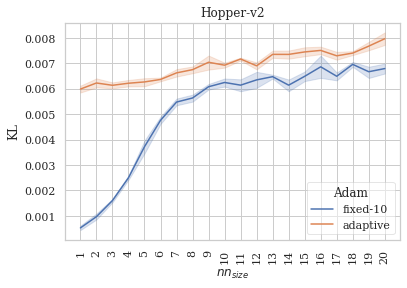

In [63]:
env = "Hopper-v2"
col= "KL"
description = r"KL"
final = False

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data = pd.concat([data,data2])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()



enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive'])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-10-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")






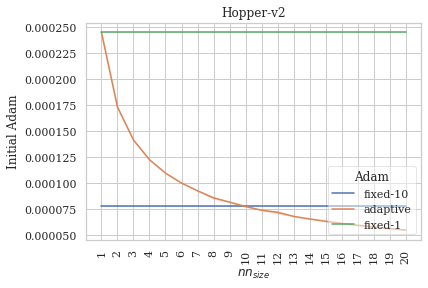

In [8]:
env = "Hopper-v2"
col= "lr"
description = r"Initial Adam"
final = False

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env,6)
data3["lr"] = data3["lr"] / 9.0 # fix graph since the learning rate coefficient was already multiplied with the initial Adam
data3.insert(0, "category2", "fixed1")


data = pd.concat([data,data2, data3])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-{col}-initial{'-final' if final else ''}.pdf", bbox_inches="tight")







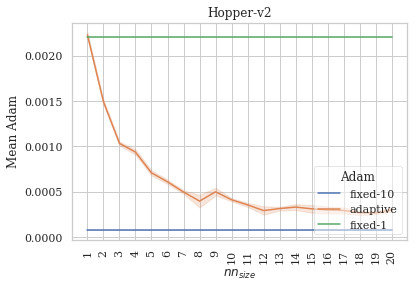

In [79]:
env = "Hopper-v2"
col= "lr"
description = r"Mean Adam"
final = False

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env, 6)

data3.insert(0, "category2", "fixed20") # append the category to compare

data = pd.concat([data,data2,data3])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data["lr"] = data["lr"] * data["lr_multiplier"]
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-lr-result.pdf", bbox_inches="tight")







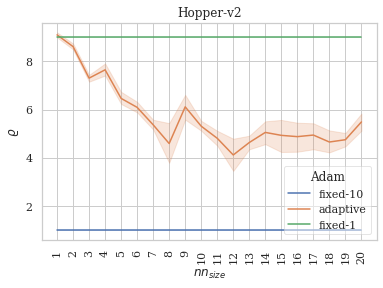

In [10]:
env = "Hopper-v2"
col= "lr_multiplier"
description = r"$\varrho$"
final = False

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env,6)
data3["lr_multiplier"] = data3["lr_multiplier"] * 9.0 # fix graph since lr mmultiplier was already multiplied
data3.insert(0, "category2", "fixed1")


data = pd.concat([data,data2, data3])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")







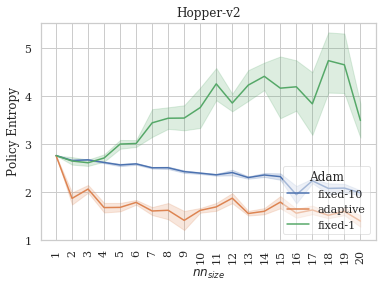

In [11]:
env = "Hopper-v2"
col= "PolicyEntropy"
description = r"Policy Entropy"
final = True

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env, 6)

data3.insert(0, "category2", "fixed1") # append the category to compare

data = pd.concat([data,data2,data3])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")








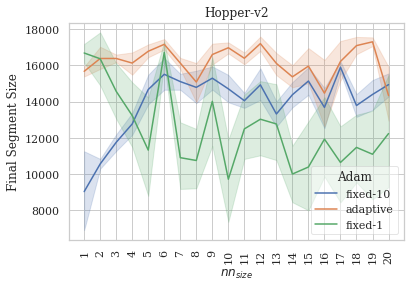

In [71]:
env = "Hopper-v2"
col= "steps"
description = r"Final Segment Size"
final = True

start_size = 1
end_size = 21
data = get_data([f"ppo-fixed-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed-{i}" for i in range(start_size,end_size)], 
                env,6)
data.insert(0, "category2", "fixed")

data2 = get_data([f"ppo-adaptive-{i}" for i in range(start_size,end_size)],
                [f"ppo-adaptive-{i}" for i in range(start_size,end_size)], 
                env, 6)
data2.insert(0, "category2", "adaptive") # append the category to compare

data3 = get_data([f"ppo-fixed1-{i}" for i in range(start_size,end_size)],
                [f"ppo-fixed1-{i}" for i in range(start_size,end_size)], 
                env, 6)
data3.insert(0, "category2", "fixed1") # append the category to compare

data = pd.concat([data,data2,data3])
data["category"] = data["category"].apply(lambda x: x.replace("fixed1","adaptive")).apply(lambda x: x.replace("fixed","adaptive"))
data
data.groupby(["category","category2","run"], sort=False)[col].mean()

enmax_palette = ["#14018B","#8B0000"]
color_codes_wanted = ['darkblue','darkred']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

policy_updates = 10 if final else 10000
data = data.groupby(["category2","category","run"], sort=False).tail(policy_updates)
g = data.groupby(["category2","category","run"], sort=False).tail(policy_updates).groupby(["category2","category","run"], sort=False)[col].mean()
g = DataFrame(g).reset_index()

plt = sns.lineplot(x="category", y = col,hue="category2",ci=95, sort=False, data=g)
plt.legend(title='Adam', loc='lower right',fancybox=True, framealpha=0.5, labels=['fixed-10','adaptive',"fixed-1"])
plt.set_xlabel(r'$nn_{size}$')
plt.set_ylabel(description)
plt.set_xticklabels([str(i) for i in range(start_size,end_size)], rotation='vertical')
plt.set_title(env)


figure = plt.get_figure() 
figure.savefig(f"ppo-nn-size-adaptive-vs-fixed-final-{col}{'-final' if final else ''}.pdf", bbox_inches="tight")









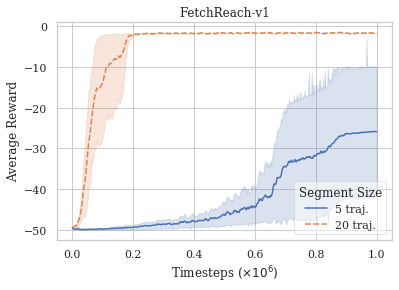

In [191]:
env = "FetchReach-v1"
cats = [f"ppo-test-rollout-size-5", "ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size-5-10"
labels = ["5 traj.", "20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

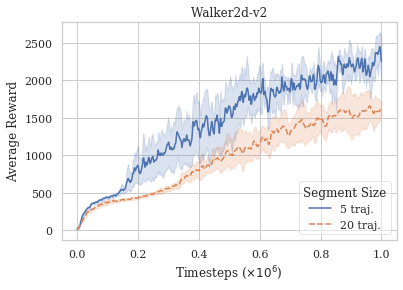

In [195]:
env = "Walker2d-v2"
cats = [f"ppo-test-rollout-size-5", "ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size-5-10"
labels = ["5 traj.", "20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

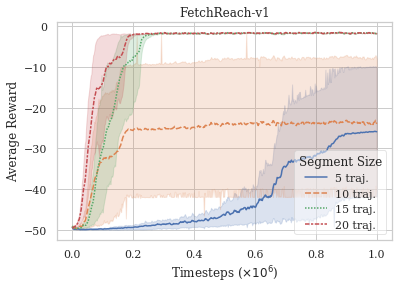

In [196]:
env = "FetchReach-v1"
cats = [f"ppo-test-rollout-size-5",f"ppo-test-rollout-size-10",f"ppo-test-rollout-size-15", "ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size"
labels = ["5 traj.", "10 traj.", "15 traj.", "20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

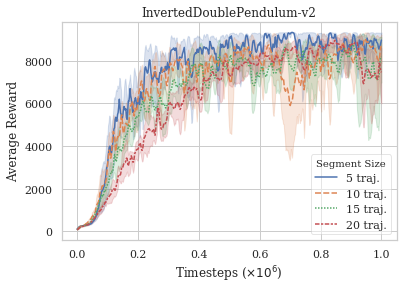

In [2]:
env = "InvertedDoublePendulum-v2"
cats = [f"ppo-test-rollout-size-5",f"ppo-test-rollout-size-10",f"ppo-test-rollout-size-15", "ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size"
labels = ["5 traj.", "10 traj.", "15 traj.", "20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

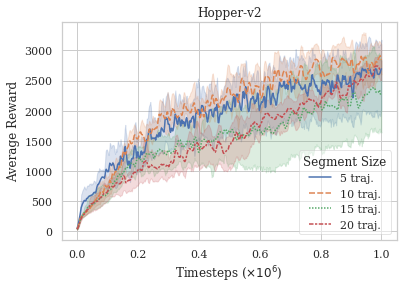

In [202]:
env = "Hopper-v2"
cats = [f"ppo-test-rollout-size-5",f"ppo-test-rollout-size-10",f"ppo-test-rollout-size-15", "ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size"
labels = ["5 traj.", "10 traj.", "15 traj.", "20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

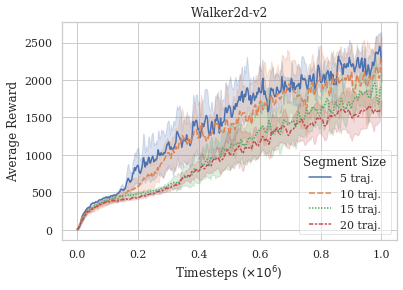

In [199]:
env = "Walker2d-v2"
cats = [f"ppo-test-rollout-size-5",f"ppo-test-rollout-size-10",f"ppo-test-rollout-size-15", "ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size"
labels = ["5 traj.", "10 traj.", "15 traj.", "20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

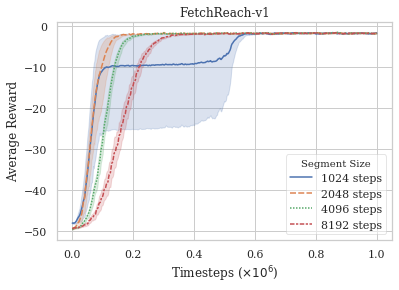

In [3]:
env = "FetchReach-v1"
cats = ["ppo-test-horizon-1024","ppo-test-horizon-2048","ppo-test-horizon-4096","ppo-test-horizon-8192"]
exp = "ppo-test-batch-size-horizon"
labels = ["1024 steps","2048 steps","4096 steps","8192 steps"]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

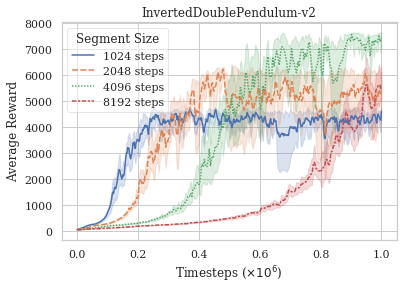

In [11]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-horizon-1024","ppo-test-horizon-2048","ppo-test-horizon-4096","ppo-test-horizon-8192"]
exp = "ppo-test-batch-size-horizon"
labels = ["1024 steps","2048 steps","4096 steps","8192 steps"]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

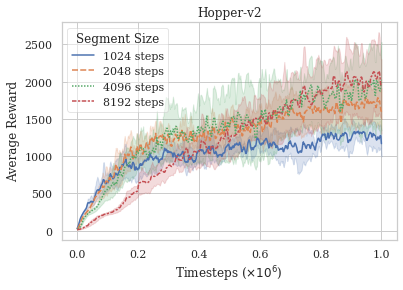

In [12]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-1024","ppo-test-horizon-2048","ppo-test-horizon-4096","ppo-test-horizon-8192"]
exp = "ppo-test-batch-size-horizon"
labels = ["1024 steps","2048 steps","4096 steps","8192 steps"]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

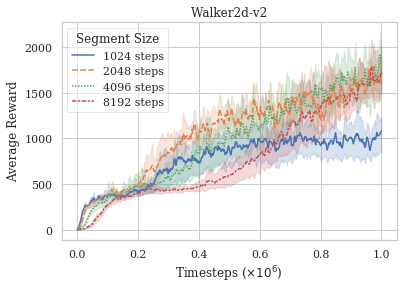

In [13]:
env = "Walker2d-v2"
cats = ["ppo-test-horizon-1024","ppo-test-horizon-2048","ppo-test-horizon-4096","ppo-test-horizon-8192"]
exp = "ppo-test-batch-size-horizon"
labels = ["1024 steps","2048 steps","4096 steps","8192 steps"]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='upper left',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

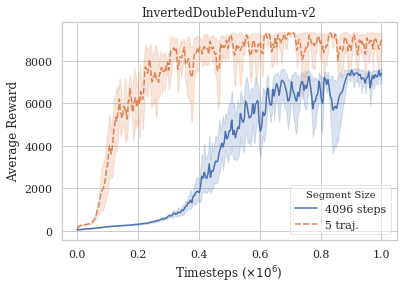

In [15]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-5"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","5 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

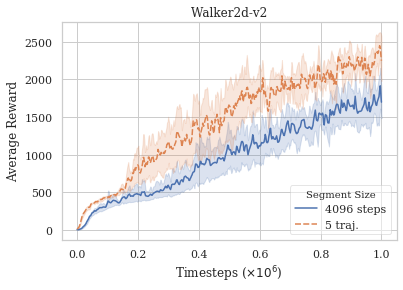

In [16]:
env = "Walker2d-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-5"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","5 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

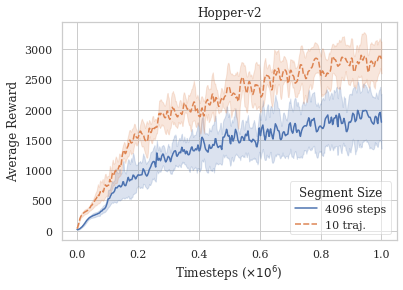

In [10]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-10"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","10 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

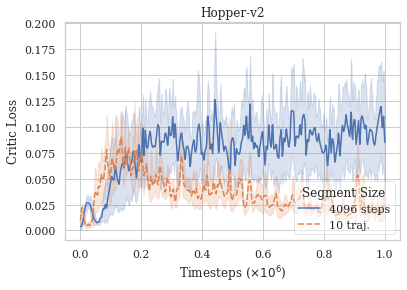

In [8]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-10"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","10 traj."]
legend_title = 'Segment Size'

#ax = plot_resampled(env,cats,y_col="ExplainedVarOld")

f = "ValFuncLoss"
df = get_data(cats,cats, env, 6)
df[f]=df[f].apply(lambda x: max(0, x)) # ignore negative values
df = resample_results(df, cats, x_col="step", y_col=f, x_max=1_000_000, samples=512)
ax = sns.lineplot(x="x", y = "y",hue="category",markers=False,dashes=dash_styles,style="category",data=df)


ax.set_ylabel("Critic Loss")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}-{f}.pdf", bbox_inches="tight")

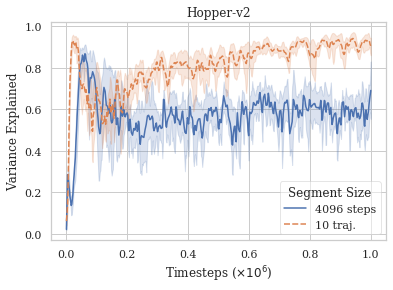

In [9]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-10"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","10 traj."]
legend_title = 'Segment Size'

#ax = plot_resampled(env,cats,y_col="ExplainedVarOld")

f = "ExplainedVarOld"
df = get_data(cats,cats, env, 6)
df[f]=df[f].apply(lambda x: max(0, x)) # ignore negative values
df = resample_results(df, cats, x_col="step", y_col=f, x_max=1_000_000, samples=512)
ax = sns.lineplot(x="x", y = "y",hue="category",markers=False,dashes=dash_styles,style="category",data=df)


ax.set_ylabel("Variance Explained")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}-{f}.pdf", bbox_inches="tight")

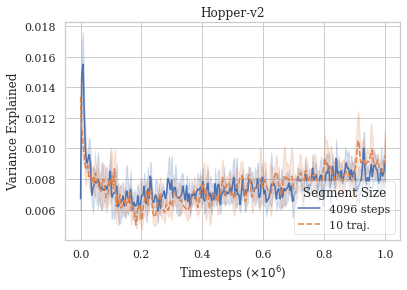

In [11]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-10"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","10 traj."]
legend_title = 'Segment Size'

#ax = plot_resampled(env,cats,y_col="ExplainedVarOld")

f = "KL"
df = get_data(cats,cats, env, 6)
df[f]=df[f].apply(lambda x: max(0, x)) # ignore negative values
df = resample_results(df, cats, x_col="step", y_col=f, x_max=1_000_000, samples=512)
ax = sns.lineplot(x="x", y = "y",hue="category",markers=False,dashes=dash_styles,style="category",data=df)


ax.set_ylabel("Variance Explained")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}-{f}.pdf", bbox_inches="tight")

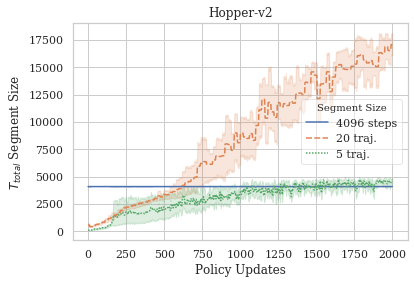

In [50]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-4096",f"ppo-adaptive-10",f"ppo-test-rollout-size-5"]
exp = "ppo-test-batch-size-comp"
labels = ["4096 steps","20 traj.","5 traj."]
legend_title = 'Segment Size'

f = "steps"
df = get_data(cats,cats, env, 6)
df=df[df["episode"]<=2000] # take first 2000 policy updates

df = resample_results(df, cats, x_col="episode", y_col=f, x_max=2000, samples=2000)
ax = sns.lineplot(x="x", y = "y",hue="category",markers=False,dashes=dash_styles,style="category",data=df)


ax.set_ylabel(r"$T_{total}$ Segment Size")
ax.set_xlabel(r"Policy Updates")
ax.legend(title=legend_title, loc='center right',fancybox=True, framealpha=0.5, labels=labels)
#ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}-segment-sizes.pdf", bbox_inches="tight")

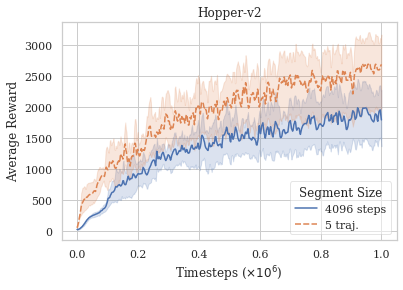

In [6]:
env = "Hopper-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-5"]
exp = "ppo-test-batch-size-comp-rew"
labels = ["4096 steps","5 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

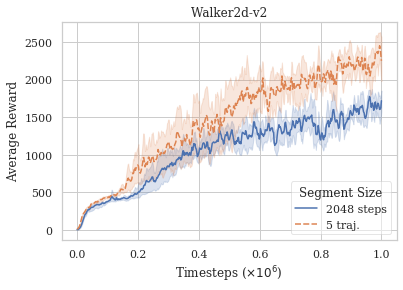

In [8]:
env = "Walker2d-v2"
cats = ["ppo-test-horizon-2048",f"ppo-test-rollout-size-5"]
exp = "ppo-test-batch-size-comp-rew"
labels = ["2048 steps","5 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

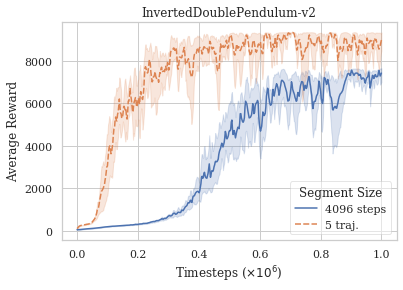

In [9]:
env = "InvertedDoublePendulum-v2"
cats = ["ppo-test-horizon-4096",f"ppo-test-rollout-size-5"]
exp = "ppo-test-batch-size-comp-rew"
labels = ["4096 steps","5 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

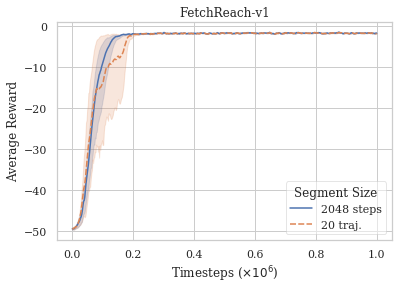

In [11]:
env = "FetchReach-v1"
cats = ["ppo-test-horizon-2048",f"ppo-test-loss-clipped_kl"]
exp = "ppo-test-batch-size-comp-rew"
labels = ["2048 steps","20 traj."]
legend_title = 'Segment Size'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

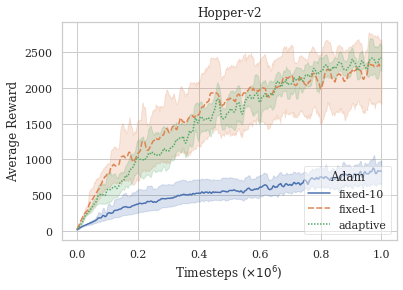

In [85]:
env = "Hopper-v2"
cats = ["ppo-fixed-1","ppo-fixed1-1","ppo-adaptive-1"]
exp = "ppo-adam-fixed-vs-dynamic-1"
labels = [r'fixed-10',"fixed-1", 'adaptive']
legend_title = 'Adam'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")


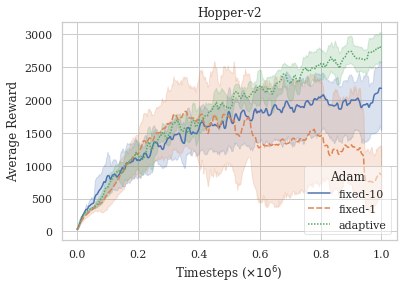

In [89]:
env = "Hopper-v2"
cats = ["ppo-fixed-10","ppo-fixed1-10","ppo-adaptive-10"]
exp = "ppo-adam-fixed-vs-dynamic-10"
labels = [r'fixed-10',"fixed-1", 'adaptive']
legend_title = 'Adam'

ax = plot_resampled(env,cats)
ax.set_ylabel("Average Reward")
ax.set_xlabel(r"Timesteps ($\times 10^6$)")
ax.legend(title=legend_title, loc='lower right',fancybox=True, framealpha=0.5, labels=labels)
ax.set_xticklabels(['{:,.1f}'.format(x) for x in ax.get_xticks()/1_000_000])
ax.set_title(env)
figure = ax.get_figure() 
figure.savefig(f"{exp}-{env}.pdf", bbox_inches="tight")

